**Group Names**: Michael Jakober, Cyril Winkler, Jaron Matzinger, Maurice Salzmann

For installing torchsummary use `pip install torchsummary`

In [1]:
from datetime import datetime
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt

## Multinomial Classification of MNIST 

1. Load the MNIST dataset by clicking through the first cells and see how to depict some samples. Please note that a training and a test dataset are loaded. Make sure that only the training set will be used for training and the test dataset just for evaluation (accuracy). 
2. Implement the multinomial logistic regression model by completing the code in the functions $\verb|linear_trsf|$, $\verb|softmax|$, $\verb|predict|$, $\verb|loss_ce|$, $\verb|cost_ce|$. 
3. Implement the mini-batch gradient descent training loop configured by number of epochs, batch size and learning rate. Implement the gradient explicitly (without autograd). Train the model with $\verb|nepochs=10|$, $\verb|nbatch=64|$ and $\verb|lr=0.01|$. 
4. Tune learning rate and batch size and qualitatively characterise the behaviour. What is your favorite combination (learning rate, batch size, number of epochs)
5. Build and train the model with full-fledge pytorch incl. autograd. Implement a model class inheriting from ```torch.nn.Module``` and use the layer functionality in the package ```torch.nn``` (see lecture). Prove that you obtain the same accuracy.


#### Hints 
* Keep an eye on the shapes of the tensors (as passed into the functions and as used within the functions (and declared in the function descriptions).
* For each implemented function, run a small test with dummy input tensors (of the required shape) and check whether it outputs a tensor with expected shape and no 'nan'.
* Possibly, add $\verb|assert()|$ statements in the code.
* For the training loop perform a training with only a single batch of size 64. Here, you should be able to obtain 100% training accuracy.

### 1. Loading the Data

Click through the cells below to load the MNIST dataset and learn how to access its samples.

#### Dataset

In [ ]:
training_data = datasets.MNIST(
    root="../data/",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="../data/",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
print(training_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
print(len(training_data))
x, y = training_data[5]
print(type(x), x.shape, x.dtype)
print(type(y), y)

60000
<class 'torch.Tensor'> torch.Size([1, 28, 28]) torch.float32
<class 'int'> 2


#### Depict samples

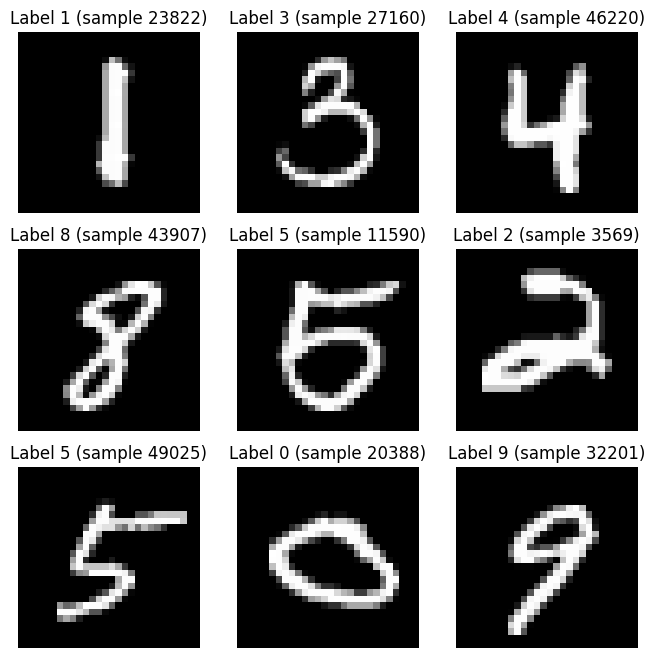

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("Label %i (sample %i)"%(label,sample_idx))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Data Loader (see lecture)

In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

In [7]:
data_train, labels_train = next(iter(train_dataloader))
print(f"Feature batch shape: {data_train.shape}")
print(f"Labels batch shape: {labels_train.shape}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


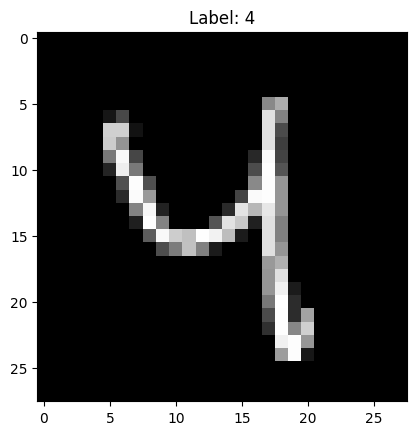

In [8]:
img = data_train[0].squeeze()
label = labels_train[0]
plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

### 2. Multinomial Logistic Regression

Now, implement the model, i.e. multinomial logistic regression and the loss/cost function (cross-entropy cost).

To that end, implement the python functions below. 
All arguments are pytorch tensors with indicated shapes.

In [9]:
def linear_trsf(x, W, b):
    """
    x -- tensor with shape (nb, 1, 28, 28) where 1 is the nr. of channels in the image
    W -- tensor with shape (10, 28 * 28)
    b -- tensor with shape (1, 10)
    """
    # YOUR CODE (START)
    nb = x.shape[0] # nb: number of samples in the batch
    x1 = x.view(nb, -1) # flattens the image dimension by reshaping to (nr. of samples, width * height)
    return x1 @ W.T + b
    # YOUR CODE (END)

def softmax(z):
    """
    z -- tensor of shape (nb, 10)
    """
    # YOUR CODE (START)
    s = torch.exp(z)
    return s / torch.sum(s, dim=1, keepdim=True) # Normalize each exp vector in the tensor
    
    # YOUR CODE (END)
    
def predict(x, W, b):
    """
    x -- tensor with shape (nb, 1, 28, 28)
    W -- tensor with shape (10, 28 * 28)
    b -- tensor with shape (1, 10)
    """
    # YOUR CODE (START)
    return softmax(linear_trsf(x, W, b))
    # YOUR CODE (END)


##### TEST

In [10]:
W, b = torch.randn((10, 28 * 28)), torch.zeros((1, 10))
print(W.shape, b.shape)
u = predict(x, W, b)
print(u.shape, torch.sum(u).item())

torch.Size([10, 784]) torch.Size([1, 10])
torch.Size([1, 10]) 0.9999999403953552


#### Loss Function

In [11]:
def loss_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    returns -- per sample loss 
    """
    # YOUR CODE (START)
    nb = y.shape[0]
    return - torch.log(uhat[torch.arange(nb), y[:]])
    # YOUR CODE (END)

def cost_ce(y, uhat):
    """
    y -- tensor with shape (nb,1) and possible values (0,1,2,3,4,5,6,7,8,9)
    uhat -- tensor with shape (nb,10)
    return -- per batch mean of losses
    """
    # YOUR CODE (START)    
    return torch.mean(loss_ce(y, uhat)) # Cost as the mean of the loss over the samples
    # YOUR CODE (END)


##### TEST

In [12]:
import numpy as np
y = torch.tensor([0,2])
z = torch.tensor([[1.,2,3], [2,2,2]]).reshape(-1,3)
uhat = softmax(z)
print(loss_ce(y,uhat), cost_ce(y,uhat))

tensor([2.4076, 1.0986]) tensor(1.7531)


### 3. Mini-Batch Gradient Descent

For the training, we adopt gradient descent - and start with the implementation of the gradient of the cost function (cross-entropy cost function).  

#### Gradient

In [13]:
def grad_loss_ce(x, u, uhat):
    """
    x -- tensor with shape (nb, 1, 28*28)
    u -- tensor with shape (nb, 10)
    uhat -- tensor with shape (nb, 10)
    returns -- gradW, gradb (same dimension as W and b)
    """
    # YOUR CODE (START)
    gradW = torch.mean((uhat - u).view(-1, 10, 1) * x.view(-1, 1, 28 * 28), dim=0)
    gradb = torch.mean((uhat - u), dim=0)
    return gradW, gradb
    # YOUR CODE (END)

#### Metrics - Cost, Accuracy

For tracking the progress of the training, we will use two functions: the cost and the accuracy. 

In [14]:
def metrics(X, Y, W, b):
    """
    X -- tensor with shape (nb, 1, 28 * 28)
    Y -- tensor with shape (nb, 10)
    W -- tensor with shape (10, 28 * 28)
    b -- tensor with shape (10, 1)
    
    return -- cost, acc (both scalars)
    """
    # YOUR CODE (START)    
    Y_hat = predict(X, W, b)
    cost = cost_ce(Y, Y_hat)
    acc = (torch.argmax(Y_hat, dim=1) == Y).float().mean()

    return cost.item(), acc.item()
    # YOUR CODE (END)

#### Training

In [15]:
nepochs = 10
alpha = 0.01
nclasses = 10
nbatch = 64
num_batches = len(training_data) / float(nbatch)

cost_hist = []
acc_hist = []
cost_hist_test = []
acc_hist_test = []

# data loader
train_dataloader = DataLoader(training_data, batch_size=nbatch, shuffle=True)

# test data - we can load all samples for the test since it easily fits into memory
X_test,y_test = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 

# initial parameters
W, b = torch.randn((10, 28 * 28)), torch.zeros((1, 10))

d0 = datetime.now()

for epoch in range(nepochs):
    cost = 0.0
    acc = 0
    for X, Y in train_dataloader:
        # Forward pass
        y_hat = predict(X, W, b)
        # Get true label from Y
        y = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses)).float()
        # Gradient Descent step
        Wgrad, bgrad = grad_loss_ce(X, y, y_hat)
        W -= alpha * Wgrad
        b -= alpha * bgrad

        # Compute metrics
    cost, acc = metrics(X, Y, W, b)
    cost_hist.append(cost)
    acc_hist.append(acc)

    with torch.no_grad():
        cost_test, acc_test = metrics(X_test, y_test, W, b)
        cost_hist_test.append(cost_test)
        acc_hist_test.append(acc_test)
        
    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    
d = datetime.now()
print((d-d0).total_seconds()/nepochs)  

Epoch 0: 4.510180, 0.500000, 4.453271, 0.385000
Epoch 1: 1.718838, 0.781250, 2.713277, 0.558800
Epoch 2: 2.241263, 0.593750, 2.064715, 0.634600
Epoch 3: 1.798844, 0.718750, 1.713956, 0.681100
Epoch 4: 1.631286, 0.687500, 1.493176, 0.716500
Epoch 5: 1.324365, 0.750000, 1.341243, 0.739000
Epoch 6: 1.214876, 0.750000, 1.229313, 0.756900
Epoch 7: 0.853808, 0.750000, 1.144433, 0.769500
Epoch 8: 1.029918, 0.812500, 1.076833, 0.780800
Epoch 9: 1.134444, 0.750000, 1.019995, 0.790500
1.6179194


Text(0.5, 1.0, 'Accuracy')

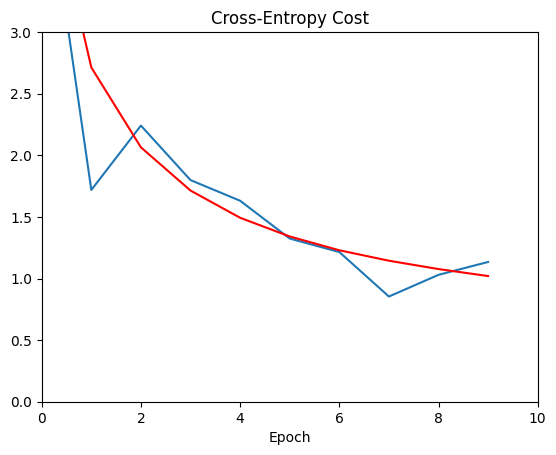

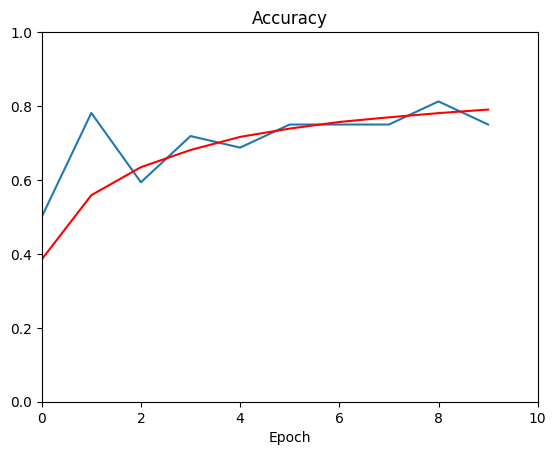

In [16]:
plt.figure(1)
plt.plot(torch.arange(nepochs), cost_hist, "-")
plt.plot(torch.arange(nepochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,3)
plt.title("Cross-Entropy Cost")
plt.figure(2)
plt.plot(torch.arange(nepochs), acc_hist,"-")
plt.plot(torch.arange(nepochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,nepochs)
plt.ylim(0,1)
plt.title("Accuracy")

### 4. Tune learning rate and batch size

Now analyse the training progress with five, well selected settings for each, the learning rate and the batch size.
Make sure that for each setting, a more or less "stable" test performance is achieved, i.e. a status where the test accurace is no longer expected to improve. Choose the number of epochs accordingly.

Finally, prepare suitable plots and tables to make the comparison transparent and characterize in words what you observe. 

Explain the behavior.

In [17]:
learning_rates = [0.001, 0.01, 0.1, 1.0, 10.0]
batch_sizes = [8, 16, 32, 64, 128]
n_epochs = 10
n_classes = 10

loss_curves_train = {}
loss_curves_test = {}

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        print(f'\nTraining with LR:{learning_rate}, Batch Size:{batch_size}')

        cost_hist = []
        acc_hist = []
        cost_hist_test = []
        acc_hist_test = []

        train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

        W, b = torch.randn((10, 28 * 28)), torch.zeros((1, 10))
        d0 = datetime.now()

        for epoch in range(n_epochs):
            cost = 0.0
            acc = 0.0
            for X, Y in train_dataloader:
                # Forward pass
                y_hat = predict(X, W, b)
                # Get true label from Y
                y = (Y.view(-1, 1) == torch.arange(nclasses).view(1, nclasses)).float()
                # Gradient Descent step
                Wgrad, bgrad = grad_loss_ce(X, y, y_hat)
                W -= alpha * Wgrad
                b -= alpha * bgrad

            # Compute metrics
            cost, acc = metrics(X, Y, W, b)
            cost_hist.append(cost)
            acc_hist.append(acc)
    
            X_test,y_test = next(iter(DataLoader(test_data, batch_size=10000, shuffle=True))) 
            with torch.no_grad():
                cost_test, acc_test = metrics(X_test, y_test, W, b)
                cost_hist_test.append(cost_test)
                acc_hist_test.append(acc_test)
                
            print(f'Epoch {epoch}: Train Cost={cost:.4f}, Train Acc={acc:.4f}, Test Cost={cost_test:.4f}, Test Acc={acc_test:.4f}')
            
        d = datetime.now()
        print(f'Time per epoch: {(d - d0).total_seconds()/n_epochs:.4f} seconds')

        loss_curves_train[(learning_rate, batch_size)] = cost_hist
        loss_curves_test[(learning_rate, batch_size)] = cost_hist_test


Training with LR:0.001, Batch Size:8
Epoch 0: Train Cost=0.5297, Train Acc=0.7500, Test Cost=1.0463, Test Acc=0.7890
Epoch 1: Train Cost=0.7433, Train Acc=0.7500, Test Cost=0.7973, Test Acc=0.8343
Epoch 2: Train Cost=0.0377, Train Acc=1.0000, Test Cost=0.6861, Test Acc=0.8537
Epoch 3: Train Cost=0.1532, Train Acc=0.8750, Test Cost=0.6233, Test Acc=0.8650
Epoch 4: Train Cost=0.0342, Train Acc=1.0000, Test Cost=0.5824, Test Acc=0.8715
Epoch 5: Train Cost=0.2478, Train Acc=0.7500, Test Cost=0.5508, Test Acc=0.8774
Epoch 6: Train Cost=0.6810, Train Acc=0.7500, Test Cost=0.5291, Test Acc=0.8802
Epoch 7: Train Cost=0.0317, Train Acc=1.0000, Test Cost=0.5082, Test Acc=0.8835
Epoch 8: Train Cost=0.0904, Train Acc=1.0000, Test Cost=0.4904, Test Acc=0.8864
Epoch 9: Train Cost=0.1687, Train Acc=0.8750, Test Cost=0.4759, Test Acc=0.8904
Time per epoch: 2.4569 seconds

Training with LR:0.001, Batch Size:16
Epoch 0: Train Cost=2.8963, Train Acc=0.5625, Test Cost=1.5696, Test Acc=0.7093
Epoch 1: Tra

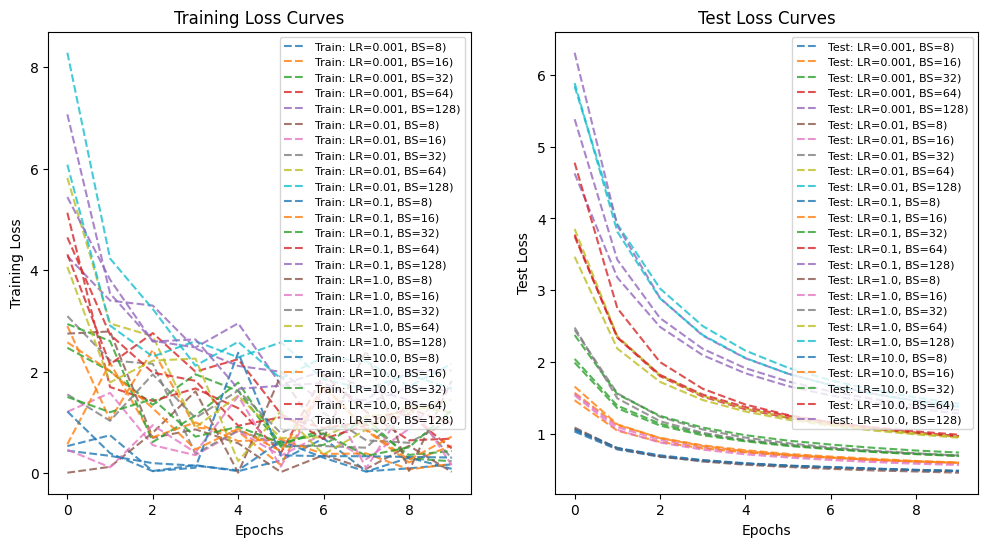

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for (lr, bs), loss in loss_curves_train.items():
    ax[0].plot(range(n_epochs), loss, label=f'Train: LR={lr}, BS={bs})', alpha=0.8, linestyle='dashed')

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
ax[0].set_title('Training Loss Curves')
ax[0].legend(loc='upper right', fontsize=8)

for (lr, bs), loss in loss_curves_test.items():
    ax[1].plot(range(n_epochs), loss, label=f'Test: LR={lr}, BS={bs})', alpha=0.8, linestyle='dashed')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Test Loss')
ax[1].set_title('Test Loss Curves')
ax[1].legend(loc='upper right', fontsize=8)

plt.show()

### 5. With Full-Fledge PyTorch

In [20]:
class NeuralNetwork(torch.nn.Module):
    
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear  = torch.nn.Linear(input_size, output_size)
    
    def forward(self, x): # use just one linear layer and pytorch's CrossEntropyLoss
        z = self.linear(self.flatten(x))
        return z

In [21]:
model = NeuralNetwork(28*28, 10)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [22]:
summary(model, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 10]                  7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [23]:
batch_size = 64
n_epochs = 10
learning_rate = 0.01

cost_hist = []
cost_hist_test = []
acc_hist = []
acc_hist_test = []

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
X_test, y_test = next(iter(test_loader))
size = len(training_loader.dataset)
n_batches = len(training_loader)

for epoch in range(nepochs):
    cost, acc = 0.0, 0.0
    for batch, (X, Y) in enumerate(training_loader):
        # Forward pass
        y_hat = model(X)
        # Compute loss
        loss = criterion(y_hat, Y)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        cost += loss.item()

        # Compute accuracy
        pred = torch.argmax(y_hat, dim=1)
        acc += (pred == Y).sum().item()

    cost /= n_batches
    acc /= size

    cost_test, acc_test = 0.0, 0.0
    with torch.no_grad():
        y_hat = model(X_test)
        loss = criterion(y_hat, y_test)
        cost_test = loss.item()
        pred = torch.argmax(y_hat, dim=1)
        acc_test = (pred == y_test).sum().item() / X_test.shape[0]

    print("Epoch %i: %f, %f, %f, %f"%(epoch, cost, acc, cost_test, acc_test))
    cost_hist.append(cost)
    cost_hist_test.append(cost_test)
    acc_hist.append(acc)
    acc_hist_test.append(acc_test)


Epoch 0: 0.975414, 0.804817, 0.599717, 0.866200
Epoch 1: 0.550496, 0.867183, 0.475496, 0.884100
Epoch 2: 0.471302, 0.879900, 0.425922, 0.891200
Epoch 3: 0.432601, 0.886650, 0.397066, 0.896100
Epoch 4: 0.408698, 0.891550, 0.378776, 0.900100
Epoch 5: 0.391874, 0.895000, 0.364986, 0.903300
Epoch 6: 0.379306, 0.897067, 0.355633, 0.905500
Epoch 7: 0.369238, 0.899383, 0.346529, 0.907300
Epoch 8: 0.361109, 0.901233, 0.339668, 0.908000
Epoch 9: 0.354730, 0.902583, 0.334713, 0.909700


Text(0.5, 1.0, 'Accuracy')

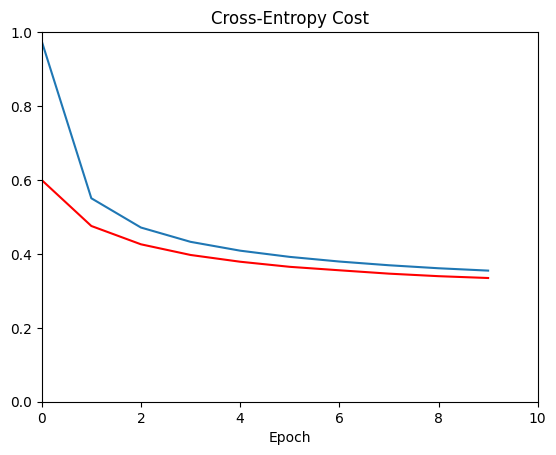

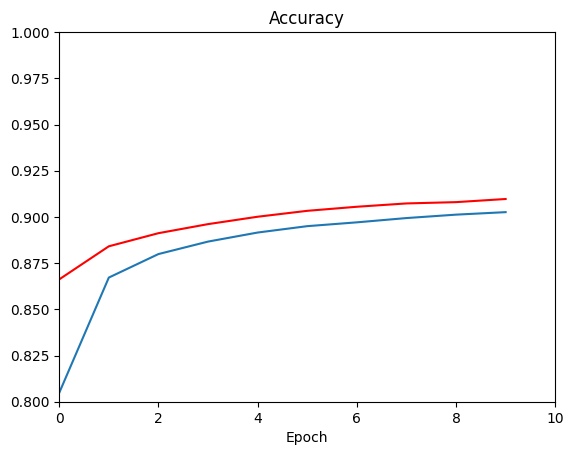

In [24]:
plt.figure(1)
plt.plot(torch.arange(n_epochs), cost_hist, "-")
plt.plot(torch.arange(n_epochs), cost_hist_test, "r-")
plt.xlabel("Epoch")
plt.xlim(0, n_epochs)
plt.ylim(0, 1)
plt.title("Cross-Entropy Cost")

plt.figure(2)
plt.plot(torch.arange(n_epochs), acc_hist,"-")
plt.plot(torch.arange(n_epochs), acc_hist_test,"r-")
plt.xlabel("Epoch")
plt.xlim(0,n_epochs)
plt.ylim(0.8, 1)
plt.title("Accuracy")